# Package

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

# Set up environment

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.92', 'gigabytes'))

# Load data

In [4]:
from preprocessing.load_dataset import raw_to_dict

In [5]:
# trainset, valset = raw_to_dict(data_mode = "small")
trainset, valset = raw_to_dict()

100%|██████████| 75039/75039 [00:00<00:00, 916113.76it/s]


>> Loading msimut at /home/kientiet/Documents/My Project/python/ucla-cs168/data/msimut
>> Total running 75039

>> Loading msimut at /home/kientiet/Documents/My Project/python/ucla-cs168/data/mss



100%|██████████| 117273/117273 [00:00<00:00, 1013720.78it/s]


>> Total running 117273

>> Splitting the dataset

>> From dictionary to data instance

>> Done!


In [7]:
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 4)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, num_workers = 4)
len(trainloader), len(valloader)

(590, 391)

torch.Size([256, 3, 224, 224]) torch.Size([256])


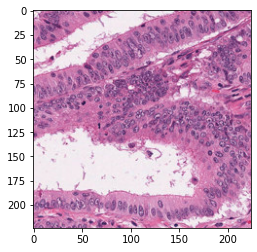

In [8]:
images, labels = next(iter(trainloader))

print(images.shape, labels.shape)
def imshow(img):
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # plt.show()

imshow(images[0])

# Baseline Model

In [9]:
from trainer.baseline_trainer import BaseLineTrainer

In [10]:
baseline_trainer = BaseLineTrainer(trainloader, valloader, num_cycle = 5)
max_epochs = baseline_trainer.get_max_epochs()

In [12]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", "baseline", "full")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = -1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full'

In [13]:
tb_logger = loggers.TensorBoardLogger('logs/', name = "baseline")
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                     nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                    logger = tb_logger
                    )

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


## Learning finder

In [14]:
lr_finder = trainer.lr_find(baseline_trainer)

INFO:lightning:
   | Name                                 | Type              | Params
-----------------------------------------------------------------------
0  | criterion                            | BCEWithLogitsLoss | 0     
1  | model                                | BaseLineModel     | 11 M  
2  | model.resnet18                       | ResNet            | 11 M  
3  | model.resnet18.conv1                 | Conv2d            | 9 K   
4  | model.resnet18.bn1                   | BatchNorm2d       | 128   
5  | model.resnet18.relu                  | ReLU              | 0     
6  | model.resnet18.maxpool               | MaxPool2d         | 0     
7  | model.resnet18.layer1                | Sequential        | 147 K 
8  | model.resnet18.layer1.0              | BasicBlock        | 73 K  
9  | model.resnet18.layer1.0.conv1        | Conv2d            | 36 K  
10 | model.resnet18.layer1.0.bn1          | BatchNorm2d       | 128   
11 | model.resnet18.layer1.0.relu         | ReLU            

INFO:lightning:LR finder stopped early due to diverging loss.


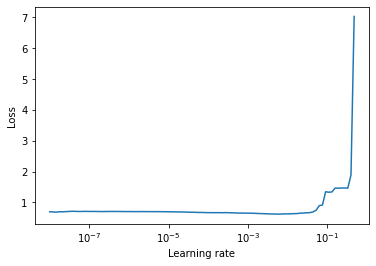

In [15]:
fig = lr_finder.plot(suggest=True)

In [16]:
baseline_trainer.base_lr = 1e-4
baseline_trainer.max_lr = 2e-2
baseline_trainer.configure_optimizers()

Adam (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.95, 0.999)
    eps: 1e-08
    initial_lr: 0.0008
    lr: 0.0007999999999999986
    max_lr: 0.02
    max_momentum: 0.95
    min_lr: 8e-08
    weight_decay: 0
)

## Train model

In [17]:
trainer.fit(baseline_trainer)

INFO:lightning:
   | Name                                 | Type              | Params
-----------------------------------------------------------------------
0  | criterion                            | BCEWithLogitsLoss | 0     
1  | model                                | BaseLineModel     | 11 M  
2  | model.resnet18                       | ResNet            | 11 M  
3  | model.resnet18.conv1                 | Conv2d            | 9 K   
4  | model.resnet18.bn1                   | BatchNorm2d       | 128   
5  | model.resnet18.relu                  | ReLU              | 0     
6  | model.resnet18.maxpool               | MaxPool2d         | 0     
7  | model.resnet18.layer1                | Sequential        | 147 K 
8  | model.resnet18.layer1.0              | BasicBlock        | 73 K  
9  | model.resnet18.layer1.0.conv1        | Conv2d            | 36 K  
10 | model.resnet18.layer1.0.bn1          | BatchNorm2d       | 128   
11 | model.resnet18.layer1.0.relu         | ReLU            

INFO:lightning:
Epoch 00001: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=1.ckpt


INFO:lightning:
Epoch 00002: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=2.ckpt


INFO:lightning:
Epoch 00003: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=3.ckpt


INFO:lightning:
Epoch 00004: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=4.ckpt


INFO:lightning:
Epoch 00005: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=5.ckpt


INFO:lightning:
Epoch 00006: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=6.ckpt


INFO:lightning:
Epoch 00007: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=7.ckpt


INFO:lightning:
Epoch 00008: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=8.ckpt


INFO:lightning:
Epoch 00009: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=9.ckpt


INFO:lightning:
Epoch 00010: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=10.ckpt


INFO:lightning:
Epoch 00011: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=11.ckpt


INFO:lightning:
Epoch 00012: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=12.ckpt


INFO:lightning:
Epoch 00013: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=13.ckpt


INFO:lightning:
Epoch 00014: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=14.ckpt


INFO:lightning:
Epoch 00015: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=15.ckpt


INFO:lightning:
Epoch 00016: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=16.ckpt


INFO:lightning:
Epoch 00017: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=17.ckpt


INFO:lightning:
Epoch 00018: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=18.ckpt


INFO:lightning:
Epoch 00019: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/baseline/full/epoch=19.ckpt


1

# Evaluate on test set

In [21]:
from evaluate.evaluator import Evaluator
from trainer.baseline_trainer import BaseLineTrainer


baseline_trainer = BaseLineTrainer(trainloader, valloader, num_cycle = 5)
checkpoint_path = "checkpoint/baseline/full/epoch=15.ckpt"
evaluator = Evaluator(baseline_trainer, checkpoint_path, trainloader, valloader)

In [22]:
evaluator.run_validation()

100%|██████████| 391/391 [01:34<00:00,  4.13it/s]

{'accuracy_score': 0.9722736785188597,
 'auc_score': 0.9967814203968042,
 'f1_score': 0.977877202093237,
 'precision_score': 0.9837957753271389,
 'recall_score': 0.9720294159691227}


In [24]:
evaluator.run_test_set()

  0%|          | 0/43 [00:00<?, ?it/s]

>> Evaluate speckle noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/speckle
Transform to dataset and loader
Start evaluating...


  0%|          | 0/43 [00:00<?, ?it/s]

{'accuracy_score': 0.6302444363371033,
 'auc_score': 0.7185194928642195,
 'f1_score': 0.6896340529781044,
 'precision_score': 0.5631407851962991,
 'recall_score': 0.8894154818325435}
>> Evaluate pepper noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/pepper
Transform to dataset and loader
Start evaluating...


  0%|          | 0/43 [00:00<?, ?it/s]

{'accuracy_score': 0.5461510397665086,
 'auc_score': 0.540173775671406,
 'f1_score': 0.18851924331376388,
 'precision_score': 0.5411985018726592,
 'recall_score': 0.1141390205371248}
>> Evaluate salt noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/salt
Transform to dataset and loader
Start evaluating...


  0%|          | 0/43 [00:00<?, ?it/s]

{'accuracy_score': 0.5859175483400219,
 'auc_score': 0.6480772217313306,
 'f1_score': 0.6391096979332274,
 'precision_score': 0.5348589675359233,
 'recall_score': 0.7938388625592417}
>> Evaluate poisson noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/poisson
Transform to dataset and loader
Start evaluating...


  0%|          | 0/43 [00:00<?, ?it/s]

{'accuracy_score': 0.621853338197738,
 'auc_score': 0.7136280022491767,
 'f1_score': 0.6827850038255546,
 'precision_score': 0.5573320009992505,
 'recall_score': 0.8811216429699842}
>> Evaluate gaussian noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/gaussian
Transform to dataset and loader
Start evaluating...


100%|██████████| 43/43 [00:05<00:00,  7.82it/s]

{'accuracy_score': 0.5846406421014229,
 'auc_score': 0.6579781508554904,
 'f1_score': 0.66371289322109,
 'precision_score': 0.5300778485491862,
 'recall_score': 0.8874407582938388}
